![](https://images.unsplash.com/photo-1585507252242-11fe632c26e8?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=700&q=60)

# Speech emotion Recognition

This notebook aims to recognize the emotion of the person from an audio sample they have recorded.

**Dataset**: The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import csv
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from PIL import Image
from librosa.display import specshow
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize, MinMaxScaler
from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import pandas as pd
import torchvision.models as models
from torch.optim.lr_scheduler import OneCycleLR 
import torch.onnx

The full dataset has audio, video and song samples. The dataset used is a subset of the above as we will be using only the audio samples.

This portion has 1440 files - 60 recordings each by 24 actors (12 male and 12 female). The actors vocalize two sentences.

The filename has & numerical parts.
* Modality
* Vocal channel
* Emotion
* Emotional intensity
* Statement
* Repetition
* Actor (odd - male; even - female)

Map of the numerical parts to the actual values.

In [ ]:
modality = ['', 'full-AV', 'video-only', 'audio-only']
vocal_channel = ['', 'speech', 'song']
emotion = ['', 'neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
emotional_intensity = ['', 'normal', 'strong']
statement = ['', 'Kids are talking by the door', 'Dogs are sitting by the door']
repetition = ['','first', 'second']
gender = ['female', 'male']

# Data extraction

This is a one-time execution process to extract characteristics and mel spectogram images of the samples.

The characteristics are saves to a csv file along wiht extracted mfccs values.

The images are be saved to the drive to be used later.

In [ ]:
'''

csvfile = open("SpeechEmotion.csv", "w")
csvwriter = csv.writer(csvfile)
csvwriter.writerow(np.concatenate((['Filename'], [i for i in range(1, 21)], ['modality','vocal_channel','emotion', 'emotional_intensity','statement','repetition','gender'])))

def extract_features(actor, files):
    for filename in tqdm.tqdm(files):
        data, sr = librosa.load('/content/drive/My Drive/Dataset/speechEmotion/'+ actor + '/' + filename)
        mfccs = np.mean(librosa.feature.mfcc(y = data, sr=sr).T, axis = 0)
        #print(mfccs.shape)
        row = np.concatenate(( ['_'.join([actor, filename])], mfccs, [modality[int(filename[1])], 
                                                                      vocal_channel[int(filename[4])], 
                                                                      emotion[int(filename[7])], 
                                                                      emotional_intensity[int(filename[10])], 
                                                                      statement[int(filename[13])], 
                                                                      repetition[int(filename[16])], 
                                                                      gender[int(actor[6:])%2] ] ))
        csvwriter.writerow(row)
        
        fig = plt.figure(figsize=[1,1])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        
        S = librosa.feature.melspectrogram(y=data, sr=sr)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', fmin=50, fmax=280)
        file  = '/content/drive/My Drive/Dataset/speechEmotion/speechEmotionInages/mel/'+actor+'_' + filename[:-4] + '.jpg'
        plt.savefig(file, dpi=500, bbox_inches='tight',pad_inches=0)

        plt.close()

        fig = plt.figure(figsize=[1,1])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        mfccs = librosa.feature.mfcc(y = data, sr=sr)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        file  = '/content/drive/My Drive/Dataset/speechEmotion/speechEmotionImages/stft/'+actor+'_' + filename[:-4] + '.jpg'
        plt.savefig(file, dpi=500, bbox_inches='tight',pad_inches=0)

        plt.close()

        fig = plt.figure(figsize=[1,1])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        mfccs = sklearn.preprocessing.scale(mfccs, axis = 1)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        file  = '/content/drive/My Drive/Dataset/speechEmotion/speechEmotionImages/stft_std/'+actor+'_' + filename[:-4] + '.jpg'
        plt.savefig(file, dpi=500, bbox_inches='tight',pad_inches=0)

        plt.close()

for i in range(1, 25):
    a = 'Actor_'+'0'*(len(str(i))%2) + str(i)
    c = os.listdir('/content/drive/My Drive/Dataset/speechEmotion/'+ a)
    print('\n', a, len(c))
    extract_features(a, c)
    print('End\n')

csvfile.close()

'''

# Creating a dataset


The csv file used in the notebook contains the extracted information.

The below link points to the extracted mel spectogram images zip file.

In [ ]:
!wget 'https://cainvas-static.s3.amazonaws.com/media/user_data/AyishaR0/speechEmotionMel.zip'

--2020-09-27 10:20:55--  https://cainvas-static.s3.amazonaws.com/media/user_data/AyishaR0/speechEmotionMel.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.62.68
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.62.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67843351 (65M) [application/x-zip-compressed]
Saving to: ‘speechEmotionMel.zip.1’

speechEmotionMel.zi  24%[===>                ]  15.90M  5.65MB/s               ^C


In [ ]:
!unzip 'speechEmotionMel.zip'

Archive:  speechEmotionMel.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of speechEmotionMel.zip or
        speechEmotionMel.zip.zip, and cannot find speechEmotionMel.zip.ZIP, period.


In [ ]:
class SpeechEmotion(Dataset):
    def __init__(self, file = None, rootdir = None, transform = None):
        self.df = pd.read_csv(file)
        self.rootdir = rootdir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.loc[i]
        fname, label = row['Filename'], row['emotion']
        ik = self.rootdir+fname[:-4]+'.jpg'
        img = Image.open(ik)
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(emotion.index(label)) 
    
    def getsr(self, i):
        row = self.df.loc[i]
        fname, label = row['Filename'], row['emotion']
        _, sr = librosa.load(self.rootdir+fname)
        return sr

## Device selection

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

# Building the model

In [ ]:
class SpeechEmotionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(emotion))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
 
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        _, pred = torch.max(out, 1)
        accuracy = torch.tensor(torch.sum(pred==labels).item()/len(pred))
        return [loss.detach(), accuracy.detach()]

## Fit and evaluate methods

In [ ]:
def fit(model, train_loader, val_loader, epochs, lr, optimizer_function = torch.optim.Adam):
    history = []
    optimizer = optimizer_function(model.parameters(), lr)
    
    for epoch in range(epochs):
        print("Epoch ", epoch)
        #Train
        model.train()
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
 
        #Validate
        result = evaluate(model, val_loader)
        print("loss: ", result["loss"], "accuracy: ", result["accuracy"], "\n")
    
        history.append(result)         
    return history

In [ ]:
def evaluate(model, loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in loader]
    outputs = torch.tensor(outputs).T
    loss, accuracy = torch.mean(outputs, dim=1)
    return {"loss" : loss.item(), "accuracy" : accuracy.item()}

In [ ]:
@torch.no_grad()
def predict_dl(model, dl):
    torch.cuda.empty_cache()
    batch_probs = []
    batch_targ = []
    for xb, yb in dl:
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        batch_targ.append(yb.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    batch_targ = torch.cat(batch_targ)
    return [list(values).index(max(values)) for values in batch_probs], batch_targ

# Mel spectogram images - CNN

## Training

In [ ]:
speech_dset = SpeechEmotion('https://cainvas-static.s3.amazonaws.com/media/user_data/AyishaR0/SpeechEmotion.csv', 'speechEmotionImages/mel/', transforms.Compose([transforms.ToTensor()]))

In [ ]:
size = len(speech_dset)
test_size = val_size = int(0.1 * size)
train_size = size - val_size - test_size

train_dset, val_dset, test_dset = random_split(speech_dset, [train_size, val_size, test_size])

print(train_size, val_size, test_size)

train_dl = DataLoader(train_dset, 16, True, num_workers=6, pin_memory=True)
val_dl = DataLoader(val_dset, 16, num_workers=6, pin_memory=True)
test_dl = DataLoader(test_dset, 16, num_workers = 6)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

1152 144 144


In [ ]:
model = to_device(SpeechEmotionModel(), device)
history = []
evaluate(model, val_dl)

{'accuracy': 0.1111111119389534, 'loss': 2.2164392471313477}

In [ ]:
torch.cuda.empty_cache()

In [ ]:
history.extend(fit(model, train_dl, val_dl, 32, 0.001))

Epoch  0
loss:  2.169728994369507 accuracy:  0.1319444477558136 

Epoch  1
loss:  1.743730902671814 accuracy:  0.5208333134651184 

Epoch  2
loss:  1.796745777130127 accuracy:  0.3402777910232544 

Epoch  3
loss:  1.830008625984192 accuracy:  0.4305555522441864 

Epoch  4
loss:  1.9046988487243652 accuracy:  0.3194444477558136 

Epoch  5
loss:  1.7570042610168457 accuracy:  0.5694444179534912 

Epoch  6
loss:  1.7969809770584106 accuracy:  0.5069444179534912 

Epoch  7
loss:  1.7335870265960693 accuracy:  0.5 

Epoch  8
loss:  1.9487626552581787 accuracy:  0.2847222089767456 

Epoch  9
loss:  1.6751344203948975 accuracy:  0.6458333134651184 

Epoch  10
loss:  1.91072416305542 accuracy:  0.375 

Epoch  11
loss:  1.671165943145752 accuracy:  0.6388888955116272 

Epoch  12
loss:  1.704332947731018 accuracy:  0.625 

Epoch  13
loss:  1.665153980255127 accuracy:  0.6319444179534912 

Epoch  14
loss:  2.067390203475952 accuracy:  0.2569444477558136 

Epoch  15
loss:  1.7126144170761108 accur

In [ ]:
history.extend(fit(model, train_dl, val_dl, 8, 0.0001))

Epoch  0
loss:  1.5909523963928223 accuracy:  0.7569444179534912 

Epoch  1
loss:  1.6111741065979004 accuracy:  0.7291666865348816 

Epoch  2
loss:  1.5859800577163696 accuracy:  0.7638888955116272 

Epoch  3
loss:  1.5965073108673096 accuracy:  0.7291666865348816 

Epoch  4
loss:  1.5816415548324585 accuracy:  0.7638888955116272 

Epoch  5
loss:  1.5849676132202148 accuracy:  0.7777777910232544 

Epoch  6
loss:  1.5974526405334473 accuracy:  0.75 

Epoch  7
loss:  1.6019591093063354 accuracy:  0.75 



In [ ]:
history.extend(fit(model, train_dl, val_dl, 8, 0.0001))

Epoch  0
loss:  1.5786197185516357 accuracy:  0.7847222089767456 

Epoch  1
loss:  1.5882000923156738 accuracy:  0.7847222089767456 

Epoch  2
loss:  1.5943114757537842 accuracy:  0.7569444179534912 

Epoch  3
loss:  1.5973057746887207 accuracy:  0.7569444179534912 

Epoch  4
loss:  1.585551381111145 accuracy:  0.7847222089767456 

Epoch  5
loss:  1.577404499053955 accuracy:  0.7847222089767456 

Epoch  6
loss:  1.584718108177185 accuracy:  0.7638888955116272 

Epoch  7
loss:  1.5882742404937744 accuracy:  0.7708333134651184 



In [ ]:
r = evaluate(model, test_dl)
yp, yt = predict_dl(model, test_dl)
print("Loss: ", r['loss'], "\nAccuracy: ", r['accuracy'], "\nF-score: ", f1_score(yt, yp, average='micro'))

Loss:  1.5732712745666504 
Accuracy:  0.8055555820465088 
F-score:  0.8055555555555556


In [ ]:
losses = []
accuracies = []
for i in history:
    losses.append(i['loss'])
    accuracies.append(i['accuracy'])

def plot(var, title):
    plt.plot(var, '-x')
    plt.title(title)

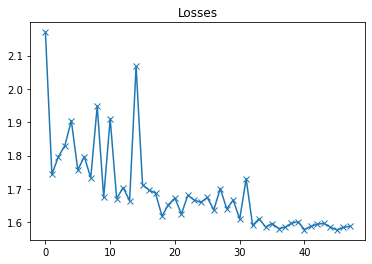

In [ ]:
plot(losses, 'Losses')

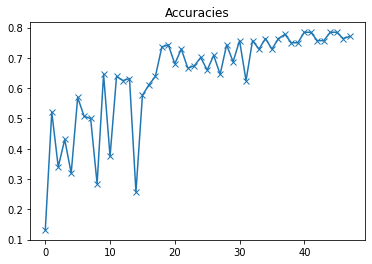

In [ ]:
plot(accuracies, 'Accuracies')

## deepC

In [ ]:
torch.save(model, '/content/speechEmotion_mel.pth')

In [ ]:
torch.load(model, '/content/speechEmotion_mel.pth')

In [ ]:
dummy = train_dset[0][0].unsqueeze(0)
torch.onnx.export(model, dummy, 'speechEmotion_mel.onnx')

!deepCC speechEmotion_mel.onnx

In [ ]:
sample = test_dtest.iloc[0]
np.savetxt('sample.data', sample)

!speechEmotion_mfccs_deepC/speechEmotion_mfccs.exe sample.data

nn_out = np.loadtxt('dense_19.out')

print("Actual: ", ytest.iloc[0].status)

print("Prediction: ", int(nn_out))

# STFT

## Training

In [ ]:
speech_dset = SpeechEmotion('https://cainvas-static.s3.amazonaws.com/media/user_data/AyishaR0/SpeechEmotion.csv', 'speechEmotionImages/stft/', transforms.Compose([transforms.ToTensor()]))

In [ ]:
size = len(speech_dset)
test_size = val_size = int(0.1 * size)
train_size = size - val_size - test_size

train_dset, val_dset, test_dset = random_split(speech_dset, [train_size, val_size, test_size])

print(train_size, val_size, test_size)

train_dl = DataLoader(train_dset, 16, True, num_workers=6, pin_memory=True)
val_dl = DataLoader(val_dset, 16, num_workers=6, pin_memory=True)
test_dl = DataLoader(test_dset, 16, num_workers = 6)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

1152 144 144


In [ ]:
model = to_device(SpeechEmotionModel(), device)
history = []
evaluate(model, val_dl)

{'accuracy': 0.0763888880610466, 'loss': 2.2026689052581787}

In [ ]:
torch.cuda.empty_cache()

In [ ]:
history.extend(fit(model, train_dl, val_dl, 32, 0.001))

Epoch  0
loss:  2.2723164558410645 accuracy:  0.0902777761220932 

Epoch  1
loss:  2.1141176223754883 accuracy:  0.1875 

Epoch  2
loss:  1.9202954769134521 accuracy:  0.2986111044883728 

Epoch  3
loss:  1.9470181465148926 accuracy:  0.3958333432674408 

Epoch  4
loss:  2.2321152687072754 accuracy:  0.1875 

Epoch  5
loss:  1.7887017726898193 accuracy:  0.4930555522441864 

Epoch  6
loss:  2.3514456748962402 accuracy:  0.0902777761220932 

Epoch  7
loss:  2.02872633934021 accuracy:  0.2430555522441864 

Epoch  8
loss:  1.9344310760498047 accuracy:  0.375 

Epoch  9
loss:  1.789681077003479 accuracy:  0.4930555522441864 

Epoch  10
loss:  1.8412089347839355 accuracy:  0.4166666567325592 

Epoch  11
loss:  1.692091464996338 accuracy:  0.5416666865348816 

Epoch  12
loss:  1.6859997510910034 accuracy:  0.6319444179534912 

Epoch  13
loss:  2.1879000663757324 accuracy:  0.1527777761220932 

Epoch  14
loss:  1.7468171119689941 accuracy:  0.5972222089767456 

Epoch  15
loss:  1.770097374916

In [ ]:
history.extend(fit(model, train_dl, val_dl, 8, 0.0001))

Epoch  0
loss:  1.6095901727676392 accuracy:  0.7222222089767456 

Epoch  1
loss:  1.6174432039260864 accuracy:  0.7291666865348816 

Epoch  2
loss:  1.6069121360778809 accuracy:  0.7361111044883728 

Epoch  3
loss:  1.613361120223999 accuracy:  0.75 

Epoch  4
loss:  1.6085357666015625 accuracy:  0.7430555820465088 

Epoch  5
loss:  1.611478567123413 accuracy:  0.7361111044883728 

Epoch  6
loss:  1.6111276149749756 accuracy:  0.7222222089767456 

Epoch  7
loss:  1.6099576950073242 accuracy:  0.7430555820465088 



In [ ]:
history.extend(fit(model, train_dl, val_dl, 16, 0.00001))

Epoch  0
loss:  1.610970377922058 accuracy:  0.7638888955116272 

Epoch  1
loss:  1.6075644493103027 accuracy:  0.7569444179534912 

Epoch  2
loss:  1.6155704259872437 accuracy:  0.7361111044883728 

Epoch  3
loss:  1.6120448112487793 accuracy:  0.7291666865348816 

Epoch  4
loss:  1.6114393472671509 accuracy:  0.7569444179534912 

Epoch  5
loss:  1.6131725311279297 accuracy:  0.75 

Epoch  6
loss:  1.612021565437317 accuracy:  0.75 

Epoch  7
loss:  1.616101622581482 accuracy:  0.7430555820465088 

Epoch  8
loss:  1.6141304969787598 accuracy:  0.7569444179534912 

Epoch  9
loss:  1.6092559099197388 accuracy:  0.7430555820465088 

Epoch  10
loss:  1.605528712272644 accuracy:  0.7638888955116272 

Epoch  11
loss:  1.6154865026474 accuracy:  0.7430555820465088 

Epoch  12
loss:  1.610883355140686 accuracy:  0.7291666865348816 

Epoch  13
loss:  1.6095690727233887 accuracy:  0.75 

Epoch  14
loss:  1.60866117477417 accuracy:  0.75 

Epoch  15
loss:  1.6236006021499634 accuracy:  0.7361111

In [ ]:
r = evaluate(model, test_dl)
yp, yt = predict_dl(model, test_dl)
print("Loss: ", r['loss'], "\nAccuracy: ", r['accuracy'], "\nF-score: ", f1_score(yt, yp, average='micro'))

Loss:  1.5800718069076538 
Accuracy:  0.7569444179534912 
F-score:  0.7569444444444444


In [ ]:
losses = []
accuracies = []
for i in history:
    losses.append(i['loss'])
    accuracies.append(i['accuracy'])

def plot(var, title):
    plt.plot(var, '-x')
    plt.title(title)

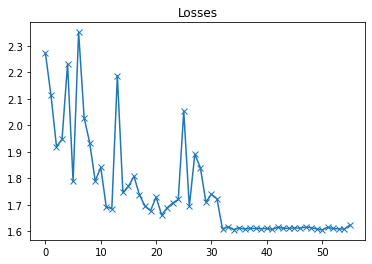

In [ ]:
plot(losses, 'Losses')

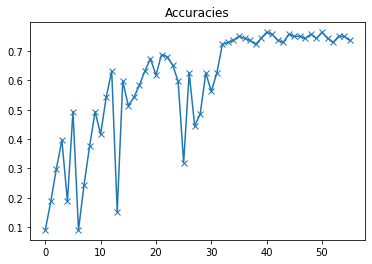

In [ ]:
plot(accuracies, 'Accuracies')

## deepC

In [ ]:
torch.save(model, '/content/speechEmotion_stft.pth')

In [ ]:
torch.load(model, '/content/speechEmotion_mel.pth')

In [ ]:
dummy = train_dset[0][0].unsqueeze(0)
torch.onnx.export(model, dummy, 'speechEmotion_mel.onnx')

!deepCC speechEmotion_mel.onnx

In [ ]:
sample = test_dtest.iloc[0]
np.savetxt('sample.data', sample)

!speechEmotion_mfccs_deepC/speechEmotion_mfccs.exe sample.data

nn_out = np.loadtxt('dense_19.out')

print("Actual: ", ytest.iloc[0].status)

print("Prediction: ", int(nn_out))

# Standardized stft

## Training

In [ ]:
speech_dset = SpeechEmotion('https://cainvas-static.s3.amazonaws.com/media/user_data/AyishaR0/SpeechEmotion.csv', 'speechEmotionImages/stft_std/', transforms.Compose([transforms.ToTensor()]))

In [ ]:
size = len(speech_dset)
test_size = val_size = int(0.1 * size)
train_size = size - val_size - test_size

train_dset, val_dset, test_dset = random_split(speech_dset, [train_size, val_size, test_size])

print(train_size, val_size, test_size)

train_dl = DataLoader(train_dset, 16, True, num_workers=6, pin_memory=True)
val_dl = DataLoader(val_dset, 16, num_workers=6, pin_memory=True)
test_dl = DataLoader(test_dset, 16, num_workers = 6)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

1152 144 144


In [ ]:
model = to_device(SpeechEmotionModel(), device)
history = []
evaluate(model, val_dl)

{'accuracy': 0.1527777761220932, 'loss': 2.1972570419311523}

In [ ]:
torch.cuda.empty_cache()

In [ ]:
history.extend(fit(model, train_dl, val_dl, 32, 0.001))

Epoch  0
loss:  2.09226131439209 accuracy:  0.2083333283662796 

Epoch  1
loss:  1.9327648878097534 accuracy:  0.3402777910232544 

Epoch  2
loss:  2.0928919315338135 accuracy:  0.2847222089767456 

Epoch  3
loss:  1.8533865213394165 accuracy:  0.3958333432674408 

Epoch  4
loss:  2.032048225402832 accuracy:  0.1736111044883728 

Epoch  5
loss:  2.120805025100708 accuracy:  0.2083333283662796 

Epoch  6
loss:  1.8099043369293213 accuracy:  0.4444444477558136 

Epoch  7
loss:  1.8589556217193604 accuracy:  0.3819444477558136 

Epoch  8
loss:  1.7530889511108398 accuracy:  0.5069444179534912 

Epoch  9
loss:  1.7508325576782227 accuracy:  0.5208333134651184 

Epoch  10
loss:  1.7624258995056152 accuracy:  0.4652777910232544 

Epoch  11
loss:  1.768691062927246 accuracy:  0.5277777910232544 

Epoch  12
loss:  1.7234476804733276 accuracy:  0.6041666865348816 

Epoch  13
loss:  1.7128417491912842 accuracy:  0.6319444179534912 

Epoch  14
loss:  2.020747184753418 accuracy:  0.347222208976745

In [ ]:
history.extend(fit(model, train_dl, val_dl, 16, 0.0001))

Epoch  0
loss:  1.6636943817138672 accuracy:  0.7152777910232544 

Epoch  1
loss:  1.6567720174789429 accuracy:  0.7013888955116272 

Epoch  2
loss:  1.6563411951065063 accuracy:  0.6875 

Epoch  3
loss:  1.6578551530838013 accuracy:  0.6944444179534912 

Epoch  4
loss:  1.6679399013519287 accuracy:  0.6875 

Epoch  5
loss:  1.6533290147781372 accuracy:  0.7083333134651184 

Epoch  6
loss:  1.6698867082595825 accuracy:  0.6875 

Epoch  7
loss:  1.664333701133728 accuracy:  0.6944444179534912 

Epoch  8
loss:  1.6567319631576538 accuracy:  0.7152777910232544 

Epoch  9
loss:  1.6531113386154175 accuracy:  0.7013888955116272 

Epoch  10
loss:  1.6758359670639038 accuracy:  0.6805555820465088 

Epoch  11
loss:  1.6638351678848267 accuracy:  0.7013888955116272 

Epoch  12
loss:  1.66373610496521 accuracy:  0.7083333134651184 

Epoch  13
loss:  1.6832810640335083 accuracy:  0.6666666865348816 

Epoch  14
loss:  1.6603890657424927 accuracy:  0.6875 

Epoch  15
loss:  1.6583186388015747 accur

In [ ]:
history.extend(fit(model, train_dl, val_dl, 32, 0.000001))

Epoch  0
loss:  1.644144892692566 accuracy:  0.7152777910232544 

Epoch  1
loss:  1.645261287689209 accuracy:  0.6944444179534912 

Epoch  2
loss:  1.6544649600982666 accuracy:  0.6944444179534912 

Epoch  3
loss:  1.649057388305664 accuracy:  0.6875 

Epoch  4
loss:  1.646468162536621 accuracy:  0.7013888955116272 

Epoch  5
loss:  1.642464518547058 accuracy:  0.7222222089767456 

Epoch  6
loss:  1.6514109373092651 accuracy:  0.7083333134651184 

Epoch  7
loss:  1.6449414491653442 accuracy:  0.7152777910232544 

Epoch  8
loss:  1.6486610174179077 accuracy:  0.7083333134651184 

Epoch  9
loss:  1.6528726816177368 accuracy:  0.7013888955116272 

Epoch  10
loss:  1.6450203657150269 accuracy:  0.7152777910232544 

Epoch  11
loss:  1.6483675241470337 accuracy:  0.7222222089767456 

Epoch  12
loss:  1.6541526317596436 accuracy:  0.7013888955116272 

Epoch  13
loss:  1.6467230319976807 accuracy:  0.7013888955116272 

Epoch  14
loss:  1.6478155851364136 accuracy:  0.7152777910232544 

Epoch  

In [ ]:
r = evaluate(model, test_dl)
yp, yt = predict_dl(model, test_dl)
print("Loss: ", r['loss'], "\nAccuracy: ", r['accuracy'], "\nF-score: ", f1_score(yt, yp, average='micro'))

Loss:  1.6943411827087402 
Accuracy:  0.6944444179534912 
F-score:  0.6944444444444444


In [ ]:
losses = []
accuracies = []
for i in history:
    losses.append(i['loss'])
    accuracies.append(i['accuracy'])

def plot(var, title):
    plt.plot(var, '-x')
    plt.title(title)

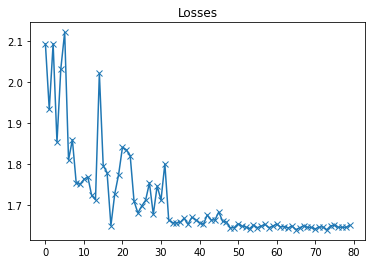

In [ ]:
plot(losses, 'Losses')

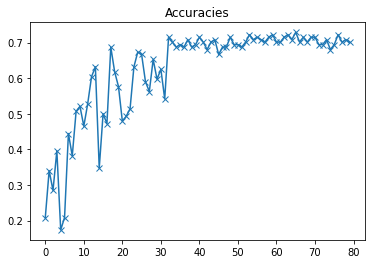

In [ ]:
plot(accuracies, 'Accuracies')

## deepC

In [ ]:
torch.save(model, '/content/speechEmotion_stft_stdz.pth')

In [ ]:
torch.load(model, '/content/speechEmotion_mel.pth')

In [ ]:
dummy = train_dset[0][0].unsqueeze(0)
torch.onnx.export(model, dummy, 'speechEmotion_mel.onnx')

!deepCC speechEmotion_mel.onnx

In [ ]:
sample = test_dtest.iloc[0]
np.savetxt('sample.data', sample)

!speechEmotion_mfccs_deepC/speechEmotion_mfccs.exe sample.data

nn_out = np.loadtxt('dense_19.out')

print("Actual: ", ytest.iloc[0].status)

print("Prediction: ", int(nn_out))